# Capstone

## Importing Libraries

In [303]:
from urllib.request import urlopen
from bs4 import BeautifulSoup as BS
from re import findall
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Data Gathering

In [101]:
df = pd.read_csv('data.csv')
df=df.sort_values(by=['County'])
df=df.reset_index(drop=True)
df.head()

,County,City,Population,Land area (sq mi)
0,Alameda,Alameda,"73,812",10.61
1,Alameda,Fremont,"2,14,089",77.46
2,Alameda,Hayward,"1,44,186",45.32
3,Alameda,Livermore,"80,968",25.17
4,Alameda,Newark,"42,573",13.87


In [102]:
# define a function to get coordinates
def get_latlng(city):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, San Francisco Bay Area, California'.format(city))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [103]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(city) for city in df["City"].tolist() ]

In [109]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_coords.head()

,Latitude,Longitude
0,37.76707,-122.24584
1,37.55135,-121.98305
2,37.67134,-122.08556
3,37.67570,-121.75856
4,37.53682,-122.03032


In [110]:
# merge the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']
print(df.shape)
df.head()

(101, 6)


,County,City,Population,Land area (sq mi),Latitude,Longitude
0,Alameda,Alameda,"73,812",10.61,37.76707,-122.24584
1,Alameda,Fremont,"2,14,089",77.46,37.55135,-121.98305
2,Alameda,Hayward,"1,44,186",45.32,37.67134,-122.08556
3,Alameda,Livermore,"80,968",25.17,37.67570,-121.75856
4,Alameda,Newark,"42,573",13.87,37.53682,-122.03032


In [107]:
# save the DataFrame as CSV file
df.to_csv("df.csv", index=False)

## Data Visualization

#### Create a map of Bay Area with cities superimposed on top

In [111]:
# get the coordinates of San Francisco Bay Area, California
address = 'San Francisco Bay Area, California'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco Bay Area, California {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco Bay Area, California 37.7884969, -122.3558473.


In [255]:
# create map of Toronto using latitude and longitude values
map_BA = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['City']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_BA)  
    
map_BA

In [114]:
# save the map as HTML file
map_BA.save('map_BA.html')

#### Check number of County and City 

In [117]:
print('The dataframe has {} County and {} City.'.format(
        len(df['County'].unique()),
        df.shape[0]
    )
)

The dataframe has 9 County and 101 City.


### Use the Foursquare API to explore the cities

In [118]:
CLIENT_ID = 'WLJZ4ORPPZETPM0KUZWQHLQUUQD15UJZVVSV42DFLCMYFFEY' # your Foursquare ID
CLIENT_SECRET = 'BJKRSVQ1WAU2RU4JRCUZHXAFI0XKENH40EHMAVRITM21XA0P' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100 # limit of number of venues returned by Foursquare API

Your credentails:
CLIENT_ID: WLJZ4ORPPZETPM0KUZWQHLQUUQD15UJZVVSV42DFLCMYFFEY
CLIENT_SECRET:BJKRSVQ1WAU2RU4JRCUZHXAFI0XKENH40EHMAVRITM21XA0P


#### Get the top 100 venues that are within a radius of 1600 meters(1 mile).

In [318]:
radius = 1600
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(df['Latitude'], df['Longitude'], df['City']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [319]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['City', 'City Latitude', 'City Longitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

print(venues_df.shape)
venues_df.head()

(6838, 7)


,City,City Latitude,City Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Alameda,37.76707,-122.24584,Alameda Theatre & Cineplex,37.764680,-122.243946,Multiplex
1,Alameda,37.76707,-122.24584,Tucker's Ice Cream,37.763843,-122.243297,Ice Cream Shop
2,Alameda,37.76707,-122.24584,American Oak,37.765739,-122.242426,Bar
3,Alameda,37.76707,-122.24584,Troy,37.764388,-122.243365,Middle Eastern Restaurant
4,Alameda,37.76707,-122.24584,The Star,37.764200,-122.242711,Pizza Place


#### Let's check how many venues were returned for each city

In [320]:
# venues_df.groupby(["City"]).count()

#### Let's find out how many unique categories can be curated from all the returned venues

In [321]:
print('There are {} uniques categories.'.format(len(venues_df['Venue Category'].unique())))

There are 391 uniques categories.


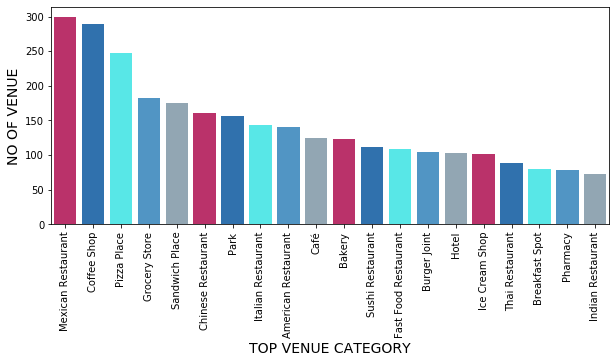

In [322]:
# Top Categories across the Bay Area
top_cat=venues_df.groupby(['Venue Category'])['Venue Name'].count()   
top_cat=top_cat.reset_index(name='Venue Name')
top_cat=top_cat.sort_values(['Venue Name'],ascending=False)
top_cat=top_cat.head(20)   
colors=['#D01C66','#1B72C2','#40FFFF','#3E99D7','#8DA7B8']

# Plot graph for top most offered roles
fig,ax=plt.subplots(figsize=(10,4))
ax=sns.barplot(x="Venue Category", y="Venue Name", data=top_cat, palette=colors)    
ax.set_xticklabels(top_cat['Venue Category'],rotation=90)
ax.set_xlabel('TOP VENUE CATEGORY',fontsize=14,color='black')
ax.set_ylabel('NO OF VENUE',fontsize=14,color='black')
plt.savefig('6.png', dpi=720)

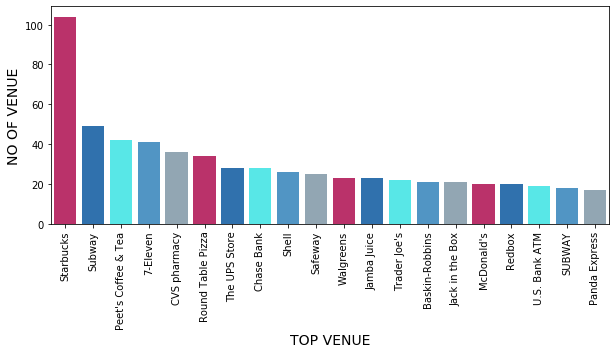

In [323]:
# Top Venue across the Bay Area
df2=venues_df.groupby(['Venue Name']).size()  
df2=df2.reset_index(name='Count')
df2=df2.sort_values(['Count'],ascending=False)
df2=df2.head(20)

# Plot graph for most jobs offering company
fig,ax=plt.subplots(figsize=(10,4))
ax=sns.barplot(x="Venue Name", y="Count", data=df2, palette=colors)    
ax.set_xticklabels(df2['Venue Name'],rotation=90)
ax.set_xlabel('TOP VENUE',fontsize=14,color='black')
ax.set_ylabel('NO OF VENUE',fontsize=14,color='black')#
plt.savefig('5.png', dpi=720)

#### Gas station across Bay Area within a mile radius of each city

In [324]:
gdf=venues_df[venues_df["Venue Category"].str.contains("Gas Station")]
gdf.shape


(37, 7)

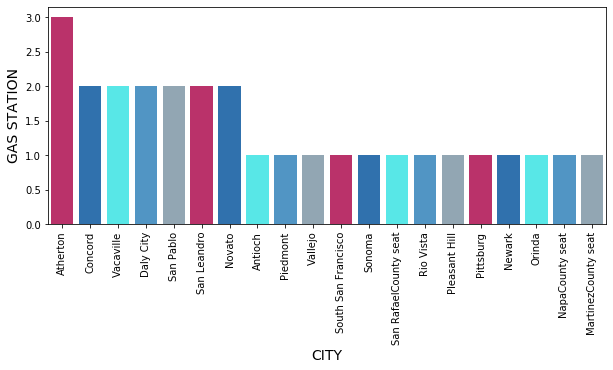

In [293]:
# Top Categories across the Bay Area
top_cat=gdf.groupby(['City'])['Venue Name'].count()   
top_cat=top_cat.reset_index(name='Venue Name')
top_cat=top_cat.sort_values(['Venue Name'],ascending=False)
top_cat=top_cat.head(20)
top_cat
# Plot graph for top most offered roles
fig,ax=plt.subplots(figsize=(10,4))
ax=sns.barplot(x="City", y="Venue Name", data=top_cat, palette=colors)    
ax.set_xticklabels(top_cat['City'],rotation=90)
ax.set_xlabel('CITY',fontsize=14,color='black')
ax.set_ylabel('GAS STATION',fontsize=14,color='black')
plt.savefig('7.png', dpi=720)

## Analyze each City with respect to Venue Category

#### Onehot code Venue Category

In [294]:
# one hot encodinggory for venue cate
onehot = pd.get_dummies(venues_df[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
onehot['City'] = venues_df['City']

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,City,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Baseball Diamond,College Football Field,College Gym,College Library,College Soccer Field,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Motel,Motorsports Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Notary,Office,Opera House,Optical Shop,Other Event,Other Great Outdoors,Other Repair Shop,Paella Restaurant,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Piercing Parlor,Pizza Place,Planetarium,Playground,Plaza,P

#### Calculate mean Category by taking occurance of each category with respect to cities

In [295]:
City_grouped = onehot.groupby('City').mean().reset_index()

#### Find 10 most common venue with respect to city

In [296]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [297]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['City'] = City_grouped['City']

for ind in np.arange(City_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(City_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alameda,Café,Mexican Restaurant,Coffee Shop,Grocery Store,Sandwich Place,Pizza Place,Asian Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Dessert Shop
1,Albany,Coffee Shop,Grocery Store,Brewery,Burger Joint,Trail,Pizza Place,Japanese Restaurant,Thai Restaurant,Mexican Restaurant,Breakfast Spot
2,American Canyon,Mexican Restaurant,Convenience Store,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Sandwich Place,Hotel,Pharmacy,Park,Ice Cream Shop
3,Antioch,Rental Car Location,Mexican Restaurant,Gym,Restaurant,Construction & Landscaping,Pizza Place,Burger Joint,Food Court,Bookstore,Gas Station
4,Atherton,Hotel,Mexican Restaurant,Pizza Place,Gas Station,Athletics & Sports,Chinese Restaurant,Asian Restaurant,Grocery Store,Coffee Shop,Food & Drink Shop



## Segmentation and Clustering

#### Create a new DataFrame for Gas Station

In [298]:
Ba_Gas = City_grouped[["City","Gas Station"]]
Ba_Gas.head()

,City,Gas Station
0,Alameda,0.000000
1,Albany,0.000000
2,American Canyon,0.000000
3,Antioch,0.038462
4,Atherton,0.062500


#### Cluster Cities

In [299]:
# set number of clusters
kclusters = 3

Ba_Gas_clustering = Ba_Gas.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Ba_Gas_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 2])

In [300]:
# add clustering labels
Ba_Gas.insert(0, 'Cluster Label', kmeans.labels_)

df_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(Ba_Gas.set_index('City'), on='City')

df_merged.head() # check the last columns!

,County,City,Population,Land area (sq mi),Latitude,Longitude,Cluster Label,Gas Station
0,Alameda,Alameda,"73,812",10.61,37.76707,-122.24584,1,0.000000
1,Alameda,Fremont,"2,14,089",77.46,37.55135,-121.98305,1,0.000000
2,Alameda,Hayward,"1,44,186",45.32,37.67134,-122.08556,2,0.010000
3,Alameda,Livermore,"80,968",25.17,37.67570,-121.75856,1,0.000000
4,Alameda,Newark,"42,573",13.87,37.53682,-122.03032,2,0.022222


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['City'], df_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Cluster

### Cluster 0

In [309]:
df_merged.loc[df_merged['Cluster Label'] == 0].head()

,County,City,Population,Land area (sq mi),Latitude,Longitude,Cluster Label,Gas Station
10,Alameda,San Leandro,"84,950",13.34,37.72832,-122.15856,0,0.027027
19,Contra Costa,San Pablo,"29,139",2.63,37.96033,-122.34239,0,0.028571
21,Contra Costa,MartinezCounty seat,"35,824",12.13,38.01393,-122.13494,0,0.032258
29,Contra Costa,Antioch,"1,02,372",28.35,38.01583,-121.81974,0,0.038462
38,Marin,Novato,"51,904",27.44,38.10609,-122.56790,0,0.028169


### Cluster 1

In [310]:
df_merged.loc[df_merged['Cluster Label'] == 1].head()

,County,City,Population,Land area (sq mi),Latitude,Longitude,Cluster Label,Gas Station
0,Alameda,Alameda,"73,812",10.61,37.76707,-122.24584,1,0.0
1,Alameda,Fremont,"2,14,089",77.46,37.55135,-121.98305,1,0.0
3,Alameda,Livermore,"80,968",25.17,37.67570,-121.75856,1,0.0
5,Alameda,OaklandCounty seat,"3,90,724",55.79,37.80508,-122.27307,1,0.0
7,Alameda,Dublin,"46,036",14.91,37.70423,-121.91635,1,0.0


### Cluster 2

In [311]:
df_merged.loc[df_merged['Cluster Label'] == 2].head()

,County,City,Population,Land area (sq mi),Latitude,Longitude,Cluster Label,Gas Station
2,Alameda,Hayward,"1,44,186",45.32,37.67134,-122.08556,2,0.010000
4,Alameda,Newark,"42,573",13.87,37.53682,-122.03032,2,0.022222
6,Alameda,Piedmont,"10,667",1.68,37.82475,-122.23235,2,0.023810
14,Contra Costa,Pleasant Hill,"33,152",7.07,37.94799,-122.06271,2,0.010638
15,Contra Costa,Pittsburg,"63,264",17.22,38.01946,-121.88851,2,0.018519


## Recommendation

#### As per analysis done in this project, it is recommended to open a gas station within the cities such as Fremont, Oakland, etc which are included in cluster 1.Cluster 1 includes cities such as Fremont, Oakland, they are the ones with high population density and low on gas station within a mile range. However, this might depend on some other factors like distance to highway which is out of scope for this capstone project.
#### Also, we can conclude that population should be correlated with the frequency of gas station. This project only considers the frequency of gas stations within the cities in the  Bay Area. However, several other factors might influence the recommendation such as , the purchasing power of consumers, distance from the community, number and type of vehicle owned by the people in those cities, etc. are not considered for recommendation.
